In [4]:
using Plots, Colors, LaTeXStrings, StatsPlots
using Plots.Measures
font_title = Plots.font("Arial", 24)
font_axis = Plots.font("Arial", 12)
font_legend = Plots.font("Arial", 8)
pyplot(titlefont=font_title, guidefont = font_axis, legendfont = font_legend)

#Define different symbols used in the plotting
delta = latexstring("\$\\delta\$")
micro = latexstring("\$\\mu\$")
vt = latexstring("\$V_t\$")
nt = latexstring("\$N_t\$")
bt = latexstring("\$B_t\$")
wt = latexstring("\$W_t\$")
i_ach = latexstring("\$I_{ACh}\$")

v_color = :deepskyblue
n_color = :magenta
c_color = :green
a_color = :purple
b_color = :red
e_color = :blue
w_color = :gray
phys_color = :black

figure_path = "C:/users/mtarc/JuliaScripts/RetinalChaos/Notebooks/Figures"

"C:/users/mtarc/JuliaScripts/RetinalChaos/Notebooks/Figures"

In [5]:
using RetinalChaos

In [21]:
import RetinalChaos: codim_map

# RetinalChaos.jl: An introduction
### In order to understand the code published here, these notebooks will act as simple tutorials on both how the model was designed. 

## Table of contents:

### [1] Introduction, Motivation, and Components
#### [1.1] Voltage and Potassium gating components of the model
#### [1.2] Calcium and the Biochemical Reactions of the sAHP
#### [1.3] Acetylcholine Diffusion and Dynamics
#### [1.4] Gaussian White noise and dynamics

### _**[2] Analyzing Data Output of the model**_
#### **[2.1] Dynamical Analysis**
#### [2.2] Fitting Experimental Data (Patch)
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers

# Just to recap the model in full is 
\begin{align}
   C_m\frac{dV}{dt} &= I_{leak} + I_{Ca} + I_K + I_{app} + I_{noise}\\
   \tau_N\frac{dN}{dt} &= \Lambda(V)(N_\infty(V) - N)\\
   \tau_C\frac{d[Ca^{2+}]}{dt} &= C_0 + \delta I_{Ca}(V) -\lambda  [Ca^{2+}]\\
   \tau_a\frac{da}{dt} &= \alpha * [Ca^{2+}]^4 * \left(1- a\right) - a\\
   \tau_b\frac{db}{dt} &= \beta * a^4 * (1 - b) - b\\
   \tau_{[ACh]}\frac{d[ACh]}{dt} &=  \nabla_{xx}^2 [ACh] + \rho \Phi(V) -[ACh]
\end{align}


### This notebook goes into more detail about the dynamical analysis conducted in notebook 1.4 and contributes to the graphs in figure 3. 

##### Using the interface I have designed, we can conduct dynamical analysis such as: 
    - Phase Plane analysis
    - Bifurcation analysis
    - Codimensional analysis

### [3.1.a] Raw network excitability
- First we will conduct an analysis of the network excitability without the effects of acetylcholine and TREK1 channels. 

In [6]:
p_dict = read_JSON("params.json") 
p_dict[:I_app] = 10.0
#p_dict[:g_ACh] = 0.0 #Remove g_ACh influence
#p_dict[:g_TREK] = 0.0 #Remove g_TREK influence
p = p_dict |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
tspan = (0.0, 60e3);
prob = ODEProblem(T_ode, u0, tspan, p)
println("Time it took to simulate 200ms:")
@time sol = solve(prob); #We will let the algorithim choose the optimal conditions to trace
trace = Array(sol)';

Time it took to simulate 200ms:
 29.870965 seconds (64.20 M allocations: 3.233 GiB, 3.69% gc time)


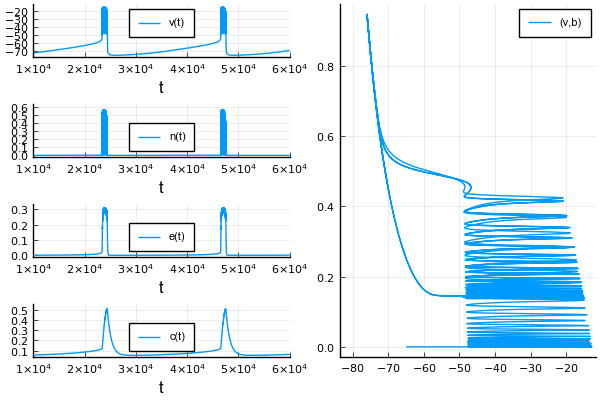

In [7]:
p1 = plot(sol, vars = [:v, :n, :e, :c], layout = grid(4,1), xlims = (10e3, 60e3))
p2 = plot(sol, vars = [(:v, :b)])
plot(p1, p2, layout = grid(1,2))

In [8]:
import RetinalChaos: phase_plane, find_equilibria

In [9]:
import RetinalChaos: ensemble_func, EnsembleProblem, SDEProblem, EnsembleThreads

In [85]:
#Make a problem, specifying all parameters
p_dict = read_JSON("params.json") 
p_dict[:I_app] = 10.0
p_dict[:g_ACh] = 0.0 #Remove g_ACh influence
p_dict[:g_TREK] = 0.0 #Remove g_TREK influence
p = p_dict |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
tspan = (0.0, 30e3);
prob = ODEProblem(T_ode, u0, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 30000.0)
u0: [-65.0, 0.0, 0.085, 0.0, 0.0, 0.0, 0.0]

In [86]:
#Run two simulations of the above
n_sims = 4
par_sym = :I_app
par = par_sym |> p_find
p_range = LinRange(-15.0, 15.0, n_sims)
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = par, rng = p_range)
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)

EnsembleProblem with problem ODEProblem

In [87]:
@time sim = solve(ensemble_prob, trajectories = n_sims, EnsembleThreads());

  3.764607 seconds (10.49 M allocations: 569.791 MiB, 2.23% gc time)


In [88]:
sfig_2a = plot(layout = grid(3,n_sims, heights = [0.60, 0.20, 0.20]), size = (1000, 600))
for nsim = 1:n_sims
    vars = [:v, :n]
    xlims = (-90.0, 0.0)
    ylims = (-0.10, 1.0)
    xspan = LinRange(xlims[1], xlims[2], 100)
    yspan = LinRange(ylims[1], ylims[2], 100)

    pp = phase_plane(sim[nsim].prob; vars = vars, xlims = xlims, ylims = ylims);
    equilibria = find_equilibria(sim[nsim].prob; vars = vars, xlims = xlims, ylims = ylims, resolution = 3);

    plot!(sfig_2a[1, nsim], sim[nsim], vars = [(vars[1], vars[2])], 
        xlims = (xspan[1], xspan[end]), ylims = (yspan[1], yspan[end]), 
        lw = 2.0, 
        c = :black, label = "Trajectory", title = ("$par_sym = $(sim[nsim].prob.p[par])"), titlefontsize = 15.0
    )
    contour!(sfig_2a[1, nsim], xspan, yspan, pp[:,:,(vars[1]|>u_find)[1]]', label = "Vt nullcline",
        levels = [0], colorbar = :none,
        c = v_color, lw = 2.0
    )
    contour!(sfig_2a[1, nsim], xspan, yspan, pp[:,:,(vars[2]|>u_find)[1]]', label = "Nt nullcline",
        levels = [0], colorbar = :none,
        c = n_color, lw = 2.0
    )

    plot!(sfig_2a[1, nsim], equilibria)

    xlabel!(sfig_2a[1, nsim], "Vt (mV)")
    ylabel!(sfig_2a[1, nsim], "Nt")
    plot!(sfig_2a[2, nsim], sim[nsim], vars = [:v],
        c = v_color, label = "", 
        xlabel = "", ylabel = "Vt (mV)", 
        margin = 0mm, lw = 2.0,
        xlims = tspan, ylims = [xlims]
    )
    plot!(sfig_2a[3, nsim], sim[nsim], vars = [:n],
        c = n_color, label = "", 
        xlabel = "", ylabel = "Nt (mV)", 
        margin = 0mm, lw = 2.0,
        xlims = tspan, ylims = [ylims]
    )
end


codim1 = (par_sym)
c1_lims = (p_range[1], p_range[end]); 
@time c1_map = codim_map(sim[1].prob, codim1, c1_lims = c1_lims, eq_res = 10);
sfig_2b = plot(c1_map, markersize = 10);

  7.990009 seconds (38.80 M allocations: 4.886 GiB, 11.41% gc time)


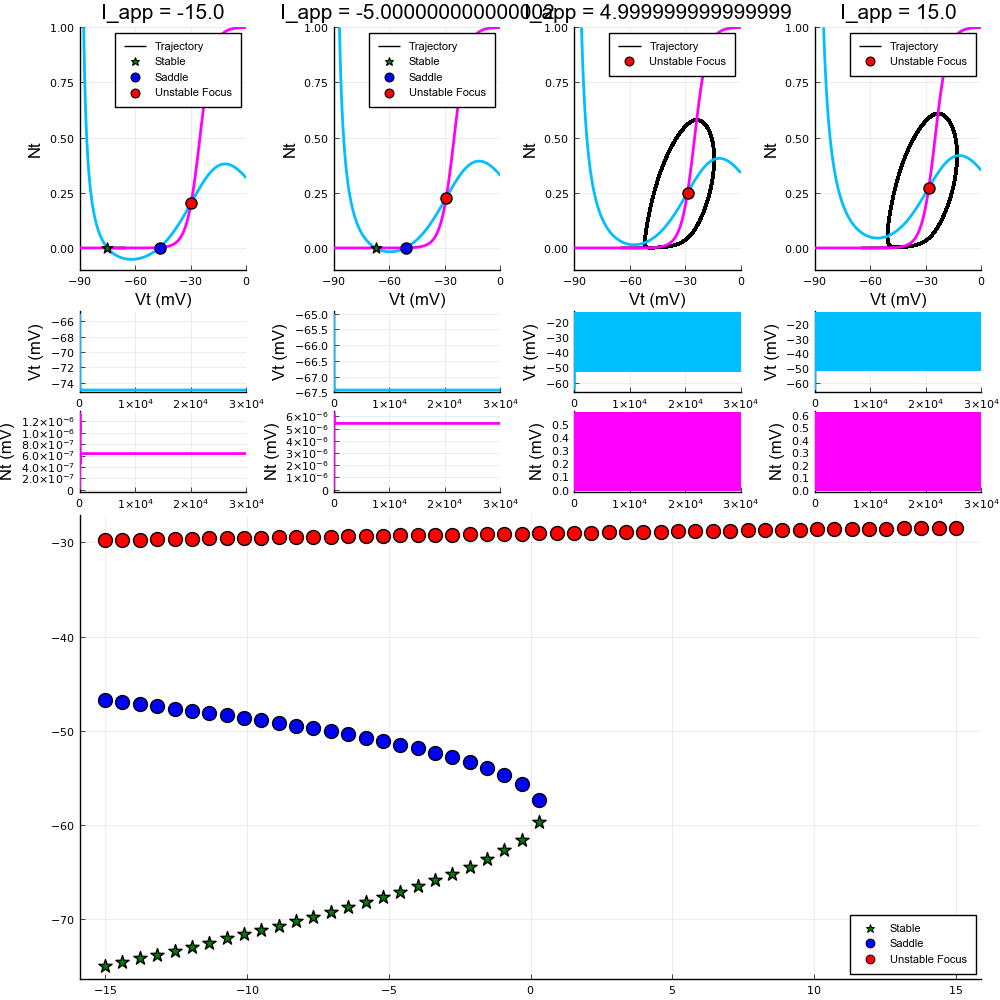

In [89]:
sfig2 = plot(sfig_2a, sfig_2b, layout = grid(2,1), size = (1000,1000))

In [90]:
p_dict = read_JSON("params.json") 
p_dict[:I_app] = 10.0
#p_dict[:g_ACh] = 0.0 #Remove g_ACh influence
p_dict[:g_TREK] = 0.0 #Remove g_TREK influence
p = p_dict |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
tspan = (0.0, 3000);
prob = ODEProblem(T_ode, u0, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 3000.0)
u0: [-65.0, 0.0, 0.085, 0.0, 0.0, 0.0, 0.0]

In [91]:
codim1 = (:I_app)
c1_lims = (-50.0, 20.0); 
@time c1_map = codim_map(prob, codim1, c1_lims = c1_lims, eq_res = 10);

  5.311289 seconds (23.93 M allocations: 2.895 GiB, 7.64% gc time)


In [ ]:
codim1 = (:I_app)
c1_lims = (-50.0, 20.0); 
@time c1_map = codim_map(prob, codim1, c1_lims = c1_lims, eq_res = 10);

In [ ]:
sfig2 = plot(sfig2_A, sfig2_B, layout = grid(2,1, heights = [0.6, 0.4]), size = (800, 1000))

### Extracting currents and checking bifurcations

In [ ]:
p_dict = read_JSON("params.json") 
p_dict[:I_app] = 10.0
p_dict[:g_ACh] = 0.0 #Remove g_ACh influence
p_dict[:g_TREK] = 0.0 #Remove g_TREK influence
p = p_dict |> extract_dict;
u0 = read_JSON("conds.json") |> extract_dict;
tspan = (0.0, 300);
prob = ODEProblem(T_ode, u0, tspan, p)
println("Time it took to simulate 200ms:")
@time sol = solve(prob); #We will let the algorithim choose the optimal conditions to trace

In [ ]:
sym_ps = map(x -> x |> Symbol, T_ode.ps);
sym_cs = map(x -> x |> Symbol, T_ode.states);

In [ ]:
p_find(:I_app)

In [ ]:
println(T_ode.ps[:I_app |> p_find])

In [ ]:
import RetinalChaos: codim_object, equilibria_object, codim_map, extract_equilibria
using LinearAlgebra, ForwardDiff, NLsolve

In [ ]:
codim2 = (:I_app, :k_d)
c1_lims = (3.0, 20.0); c2_lims = (-60.0, 60.0) 
@time c2_map = codim_map(prob, codim2, c1_lims = c1_lims, c2_lims = c2_lims);

In [ ]:
top = plot(c2_map; view = :xyz, 
    xlabel = "$(codim2[1])", ylabel = "$(codim2[2])", zlabel = "Equilibria Voltage");

In [ ]:
p1 = plot(c2_map; view = :xz, 
    xlabel = "$(codim2[1])", ylabel = "Equilibria Voltage")
p2 = plot(c2_map; view = :xy, 
    xlabel = "$(codim2[1])", ylabel = "$(codim2[2])", zlabel = "Equilibria Voltage")
p3 = plot(c2_map; view = :yz, 
    xlabel = "$(codim2[2])", ylabel = "Equilibria Voltage"
)
mid = plot(p1, p2, p3, layout = grid(1,3));

In [ ]:
thresholds = RetinalChaos.extract_thresholds(c2_map)
baselines = RetinalChaos.extract_baselines(c2_map)

bottom1 = plot(c2_map; view = :baselines, 
        xlabel = "$(codim2[1])", ylabel = "$(codim2[2])", 
        xticks = collect(c1_lims[1]:1:c1_lims[2]), yticks = collect(c2_lims[1]:1:c2_lims[2])
    )
bottom1 = contourf!(bottom1, baselines, 
    levels = [-65.0, -57.0], c = :red, alpha = 0.2, label = "Physiological baseline", 
    title = "Baseline Voltage (mV)", titlefontsize = 12.0
    );

bottom2 = plot(c2_map; view = :thresholds, 
    xlabel = "$(codim2[1])", ylabel = "$(codim2[2])", 
    xticks = collect(c1_lims[1]:1:c1_lims[2]), yticks = collect(c2_lims[1]:1:c2_lims[2])
)

bottom2 = contourf!(bottom2, thresholds, 
    levels = [-49.0, -40.0], c = :green, alpha = 0.2, label = "Physiological baseline", 
    title = "Threshold Voltage (mV)", titlefontsize = 12.0
    
)
bottom = plot(bottom1, bottom2, layout = grid(1,2));

In [ ]:
plot(top, mid, bottom, layout = grid(3, 1, heights = [0.5, 0.25, 0.25]), size = (800,1000))

In [ ]:
p_dict = read_JSON("params.json", is_type = Dict{Symbol, Float64});
u_dict = read_JSON("conds.json", is_type = Dict{Symbol, Float64});
#For the bifurcation analysis we can null out the 
p_dict[:g_TREK] = 0.0
p_dict[:σ] = 0.0

p_dict[:g_Ca] = 11.0
p_dict[:g_K] = 10.0
p_dict[:I_app] = 4.0

#p_dict[:V3] = -30.0
p0 = map(x -> Float64(p_dict[x]), BurstModel.params); pi = copy(p0);
u0 = map(x -> Float64(u_dict[x]), BurstModel.syms); ui = copy(u0);
tspan = (0.0, 500.0);
prob = ODEProblem(BurstModel, u0, tspan, p0);
println("Time it took to simulate 200ms:")
@time sol = solve(prob);

vars = [:v, :n]
xlims = (-90.0, 0.0)
ylims = (-0.10, 1.0)
xspan = LinRange(xlims[1], xlims[2], 100)
yspan = LinRange(ylims[1], ylims[2], 100)
pp = phase_plane(ui, pi; vars = vars, xlims = xlims, ylims = ylims);
equilibria = find_equilibria(ui, pi; vars = vars, xlims = xlims, ylims = ylims, resolution = 3);

sfig2_Ab1 = plot(sol, vars = [(vars[1], vars[2])], 
    xlims = (xspan[1], xspan[end]), ylims = (yspan[1], yspan[end]), 
    lw = 2.0, 
    c = :black, label = "Trajectory", title = ("$(i_app) = $(p_dict[:I_app])pA"), titlefontsize = 15.0
)

contour!(sfig2_Ab1, xspan, yspan, pp[:,:,(vars[1]|>u_find)[1]]', label = "Vt nullcline",
    levels = [0], colorbar = :none,
    c = v_color, lw = 2.0
)
contour!(sfig2_Ab1, xspan, yspan, pp[:,:,(vars[2]|>u_find)[1]]', label = "Nt nullcline",
    levels = [0], colorbar = :none,
    c = n_color, lw = 2.0
)

plot!(sfig2_Ab1, equilibria)
xlabel!(sfig2_Ab1, "Vt (mV)")
ylabel!(sfig2_Ab1, "Nt")
sfig2_Ab2 = plot(sol, vars = [:v, :n], layout = grid(2, 1), 
    c = [v_color n_color], label = "", 
    xlabel = ["" "Time (ms)"], ylabel = ["Vt (mV)" "Nt"], 
    margin = 0mm, lw = 2.0 ,
    xlims = tspan, ylims = [xlims ylims]
)
sfig2_Ab = plot(sfig2_Ab1, sfig2_Ab2, layout = grid(2, 1, heights = [0.6, 0.4]), size = (400, 600))

In [ ]:
p_dyn = :g_K
p_range = LinRange(1.0, 20.0, 100)
sfig2_B = plot(size = (1000, 500), ylabel = "Nt", zlabel = "Vt(mV)", xlabel = p_dyn, 
    #xlims = (p_range[1], p_range[end]), ylims = xlims, zlims = ylims
)
for val in p_range
    pv = copy(p0)
    uv = copy(u0)
    pv[(p_dyn |> p_find)...] = val
    
    equilibria = find_equilibria(uv, pv, resolution = 10)
    if equilibria.unstable_focus != [] && equilibria.stable == []
        prob = ODEProblem(BurstModel, equilibria.unstable_focus[1], tspan, pv);
        sol = solve(prob, saveat = 1.0);
    else
        prob = ODEProblem(BurstModel, uv, tspan, pv);
        sol = solve(prob, saveat = 1.0);
    end
    vt = map(x -> sol(x)[1], sol.t)
    nt = map(x -> sol(x)[2], sol.t)
    z = repeat([val], length(nt))
    
    plot!(sfig2_B, z, nt, vt, label = "", c = :black)
    plot!(sfig2_B, val, equilibria, view = :zyx, label = "")
end
sfig2_B

In [ ]:
plot(sfig2_Ab, sfig2_B, layout = grid(1, 2, widths = [0.3, 0.7]))

### In order to make sense of a bifurcation analysis we can use the ensemble approach to the model

In [ ]:
n_sims = 50
par = :I_app
p_range = LinRange(-5.0, 4.0, n_sims)
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = [par], par_range = p_range)
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)

In [ ]:
@time sim = solve(ensemble_prob, saveat = 100.0, trajectories = n_sims, EnsembleThreads());
sim[1] |> size

In [ ]:
p = plot(layout = grid(4, 2), size = (1000, 1000))
for (idx, traj) in enumerate(sim)
    val = p_range[idx]
    t = sol.t
    vt = map(t -> traj(t)[1], sol.t)
    nt = map(t -> traj(t)[2], sol.t)
    ct = map(t -> traj(t)[3], sol.t)
    at = map(t -> 1-traj(t)[4], sol.t)
    bt = map(t -> traj(t)[5], sol.t)
    z = repeat([val], length(vt))
    plot!(p[1,1], z, nt, vt,  
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = par, ylabel = :Nt, zlabel = :Vt, legend = :none)
    plot!(p[1,2], z, t, vt, 
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = par, ylabel = :t, zlabel = :Vt, legend = :none)
    
    plot!(p[2,1], z, at, ct,  
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = par, ylabel = :At, zlabel = :Ct, legend = :none)
    plot!(p[2,2], z, t, ct, 
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = par, ylabel = :t, zlabel = :Ct, legend = :none)
    
    plot!(p[3,1], z, bt, at,  
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = par, ylabel = :Bt, zlabel = :At, legend = :none)
    plot!(p[3,2], z, t, at, 
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = par, ylabel = :t, zlabel = :At, legend = :none)
    
    plot!(p[4,1], z, ct, bt,  
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = par, ylabel = :Ct, zlabel = :Bt, legend = :none)
    plot!(p[4,2], z, t, bt, 
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = par, ylabel = :t, zlabel = :Bt, legend = :none)
end
p

In [ ]:
p = plot(layout = grid(1, 2), size = (1000, 500))
for (idx, traj) in enumerate(sim)
    val = p_range[idx]
    t = sol.t
    vt = map(t -> traj(t)[1], sol.t)
    nt = map(t -> traj(t)[2], sol.t)
    ct = map(t -> traj(t)[3], sol.t)
    at = map(t -> 1-traj(t)[4], sol.t)
    bt = map(t -> traj(t)[5], sol.t)
    z = repeat([val], length(vt))    
    plot!(p[1,1], z, nt, vt,  
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = :alpha, ylabel = :Nt, zlabel = :Vt, legend = :none)
    plot!(p[1,2], z, t, vt, 
        line_z = val, c = :delta, clim = (p_range[1], p_range[end]), 
        xlabel = :alpha, ylabel = :t, zlabel = :Vt, legend = :none)
end
p

In [ ]:
vars = [(:v, :n)]
p = plot(layout = grid(length(vars),1), size = (800, 800))
for (idx, traj) in enumerate(sim)
    val = p_range[idx]
    plot!(p, traj, vars = vars, c = :delta, line_z = val, clim = (p_range[1], p_range[end]), legend = :none)
end
#p